**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [16]:
from types import SimpleNamespace
from scipy import optimize
from scipy import interpolate
import numpy as np
import sympy as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [17]:
# We define symbols
alpha =sm.symbols('alpha')
kappa =sm.symbols('kappa')
nu =sm.symbols('nu')
w_hat =sm.symbols('w_hat')
L=sm.symbols('L')
G=sm.symbols('G')

# We define some parameter values
tau = 0.3
w = 1

# We define the consumption function
C = kappa+w_hat*L

# We define the utility function
V = sm.log(C**alpha*G**(1-alpha))-nu*L**2/2

# At first we differentiate the utility function with respect to L and put this expression equal to zero
L_diff = sm.diff(V,L)
L_diff_eq = sm.Eq(L_diff,0)

# We solve the equation for L and display the solution
L_solve=sm.solve(L_diff_eq,L)[1]
print('The optimal labor supply choice is:')
display(L_solve)

# Plugging in the baseline parameter values 
L_solve_num = sm.lambdify(args=(alpha,kappa,nu,w_hat),expr=L_solve)
L_solve_num(0.5, 1, 1/(2*16**2), (1-tau)*w)

# We also plug in the parameter values in the expression we got in the paper
L_test = (-1+(1**2+4*0.5/(1/(2*16**2))*((1-0.3)*1)**2)**0.5)/(2*(1-0.3)*1)
print('The numerically optimal labor supply choice is in the exam paper:')
print(f'{L_test:.3f}')
print('The numerically optimal labor supply choice analytically is:')
print(f'{L_solve_num(0.5, 1, 1/(2*16**2), (1-tau)*w):.3f}')


The optimal labor supply choice is:


(-kappa*nu + sqrt(nu*(4*alpha*w_hat**2 + kappa**2*nu)))/(2*nu*w_hat)

The numerically optimal labor supply choice is in the exam paper:
15.302
The numerically optimal labor supply choice analytically is:
15.302


Since the expression we get is a bit more complicated than the one we got in the paper, we will try to make it clear that it is the same expression by plugging in the baseline parameter values in both expressions. \
From here we can verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$. 

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1/2)*(-kappa*nu + sqrt(nu*(4*alpha*w_hat**2 + kappa**2*nu)))/(nu*w_hat)


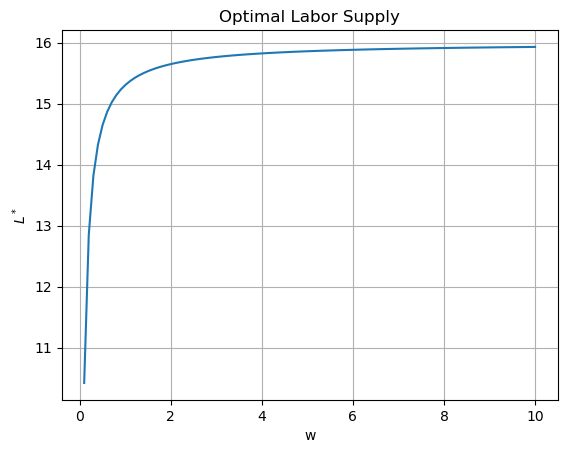

In [18]:
# We define the range of w values
w_values = np.linspace(0, 10, 100)  # Adjust the range and number of points as needed

# We create an empty list to store the optimal labor supply choices
L_optimal_values = []

# We calculate the optimal labor supply choice for each w value
for w_value in w_values:
    L_optimal = L_solve_num(0.5, 1, 1/(2*16**2), (1-tau)*w_value)
    L_optimal_values.append(L_optimal)

# We plot the relationship between L* and w
plt.plot(w_values, L_optimal_values)
plt.xlabel('w')
plt.ylabel('$L^*$')
plt.title('Optimal Labor Supply')
plt.grid(True)
plt.show()

From the figure we can note that as w increases $L^*$ also increases. \
Even though $L^*$ increases, $L^*$ also seems to have an upper bound as the increase seems to be stagnant. 


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


C:\Users\adamk\AppData\Local\Temp\ipykernel_16628\2916484547.py:21: RuntimeWarning: divide by zero encountered in log
  utility = np.log((1+(1-tau)*w*L)**0.5*G**0.5)-(1/(2*16**2))*L**2/2


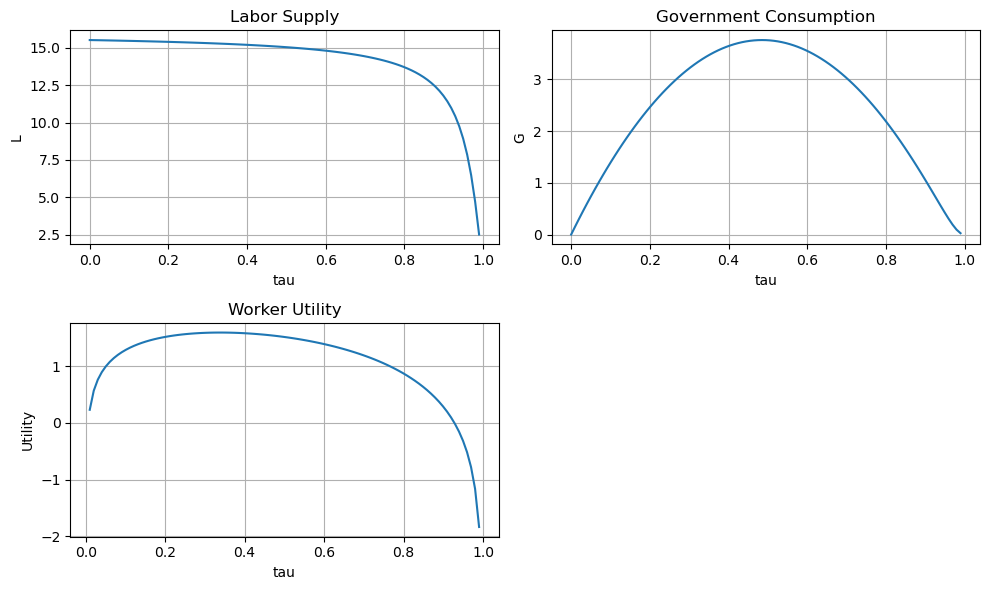

In [19]:
# We define the grid of tau-values
tau_values = np.linspace(0, 1, 100)

# We create empty lists to store the values of L, G, and worker utility
L_values = []
G_values = []
utility_values = []

# We calculate the values of L, G, and worker utility for each tau-value
for tau in tau_values:

    # We calculate L
    L = L_solve_num(0.5, 1, 1/(2*16**2), (1-tau) * w)
    L_values.append(L)

    # We calculate G
    G = tau * w * L * (1-tau)*w
    G_values.append(G)

    # We calculate worker utility
    utility = np.log((1+(1-tau)*w*L)**0.5*G**0.5)-(1/(2*16**2))*L**2/2
    utility_values.append(utility)

# We plot the values of L, G, and worker utility against tau
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(tau_values, L_values)
plt.xlabel('tau')
plt.ylabel('L')
plt.title('Labor Supply')
plt. grid(True)

plt.subplot(2, 2, 2)
plt.plot(tau_values, G_values)
plt.xlabel('tau')
plt.ylabel('G')
plt.title('Government Consumption')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(tau_values, utility_values)
plt.xlabel('tau')
plt.ylabel('Utility')
plt.title('Worker Utility')
plt.grid(True)

plt.tight_layout()
plt.show()


Here we have plotted Labor Supply, Government Consumption and worker utility for different values of $\tau$. \

It can be noticed that as tau increases, Labor Supply decreases. \
The intuition behind this result is that you do not want to work if the tax rate is too high. 

In terms of Government Consumption, it seemes to be at its highest at a $\tau$-value of 0.5. \
As seen in the figure there is a point as tau increases, where government consumption decreases. This is also refered to as the Laffer Curve, which is a theory of an optimal taxrate in order to generate maximal government consumption. As tau increases government consumption decreases as the incentive to work goes away as all of your money goes to the government. A tau of 0 will of course mean 0 government consumption. 

Worker Utility starts of by increasing and as it reaches a certain point around 0.4 it starts decreasing. We will look further into that in Question 4. \
The intuition is kind of the same is with labor supply, but in this case there comes a point where workers get a negative utility as he tax rate gets too high. The workers do not want to work if they pay too much in tax. 

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

The optimal tau value is: 0.392


C:\Users\adamk\AppData\Local\Temp\ipykernel_16628\1233026056.py:28: RuntimeWarning: divide by zero encountered in log
  utility_val = np.log((1 + w_val * L_val) ** 0.5 * tau * 1 * L_val ** ((1 - tau) * 1) ** 0.5) - (1 / (2 * 16 ** 2)) * L_val ** 2 / 2


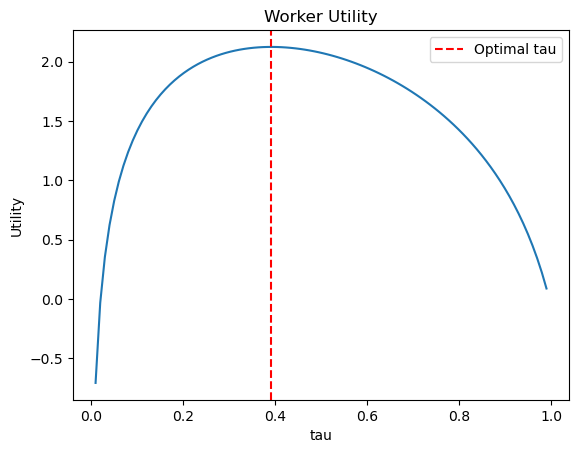

In [20]:
# We define the objective function to be maximized
def objective_function(tau):
    w_val = (1 - tau) * 1
    L_val = L_solve_num(0.5, 1, 1 / (2 * 16 ** 2), w_val)
    utility_val = np.log((1 + w_val * L_val) ** 0.5 * tau * 1 * L_val ** ((1 - tau) * 1) ** 0.5) - (1 / (2 * 16 ** 2)) * L_val ** 2 / 2
    return -utility_val 

# We set the bounds for tau
bounds = (0, 1)

# We use the minimize_scalar function to find the optimal tau
result = optimize.minimize_scalar(objective_function, bounds=bounds, method='bounded')

# We extract the optimal tau value
optimal_tau = result.x

# We print the optimal tau value
print(f'The optimal tau value is: {optimal_tau:.3f}')

# We create a grid of tau values for plotting
tau_values = np.linspace(0, 1, 100)

# We calculate the corresponding worker utility values for each tau value
utility_values = []
for tau in tau_values:
    w_val = (1 - tau) * 1
    L_val = L_solve_num(0.5, 1, 1 / (2 * 16 ** 2), w_val)
    utility_val = np.log((1 + w_val * L_val) ** 0.5 * tau * 1 * L_val ** ((1 - tau) * 1) ** 0.5) - (1 / (2 * 16 ** 2)) * L_val ** 2 / 2
    utility_values.append(utility_val)

# We plot the worker utility against tau
plt.plot(tau_values, utility_values)
plt.xlabel('tau')
plt.ylabel('Utility')
plt.title('Worker Utility')
plt.axvline(x=optimal_tau, color='r', linestyle='--', label='Optimal tau')
plt.legend()
plt.show()


As seen in the figure, the socially optimal tax rate is given at $\tau$ equal to 0.392. \
This is the value of $\tau$ maximizing worker utility.

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [21]:
#Define the given parameters for set 1
kappa = 1
alpha = 0.5
nu = 1 / (2 * 16 ** 2)
w = 1
sigma = 1.001
rho = 1.001
epsilon = 1
tau = 0.392
w_hat = (1 - tau) * w
G = 1.5  #G has to be given intial value to optimize, so we let intial value of G be 1.5

#We define the utility function for the worker
def utility_function(L, w_hat, G):
    C = kappa + w_hat * L
    A = ((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma-1))) ** (1-rho)
    B = (1 - rho)
    D = nu * (L ** (1 + epsilon) / (1 + epsilon))
    return (A - 1) / B - D


#We now let the utility function for the worker have a negative sign since we minimize, 
#We define this new function as obj_func with only L as an args, since we only minimize with respect to L
def obj_func(L):
    return -utility_function(L, w_hat, G)


#We the obj_func with respect to L within the bounds of (0,24) and let our intial guess of L be 8
bounds = [(0, 24)]
result = optimize.minimize(obj_func, x0=[8.0], bounds=bounds)
optimal_L_1 = result.x[0] #We rename our result as optimal_L_1

#We can now calculate the true G (the optimal G) with optimal_L_1 we finded above
optimal_G_1 = tau * w * optimal_L_1

#Calculate the utility with the optimal values for L and G
utility_1 = utility_function(optimal_L_1, w_hat, optimal_G_1)

#We define the given parameters for set 2
sigma = 1.5
rho = 1.5

#We now run our optimize code, but now for the set 2 parameters
result2 = optimize.minimize(obj_func, x0=[8.0], bounds=bounds)
optimal_L_2 = result2.x[0] #We rename our result as optimal_L_2

#We can now calculate the true G (the optimal G) with optimal_L_2 in set 2 we finded above
optimal_G_2 = tau * w * optimal_L_2

#Calculate the utility with the optimal values for L and G in set
utility_2 = utility_function(optimal_L_1, w_hat, optimal_G_1)

#Print the results
print(f"Optimal Labor Supply, L, in set 1 = {optimal_L_1:.3f}")
print(f"Optimal G, in set 1 = {optimal_G_1:.3f}")
print(f"Utility with optimal L and G, in set 1 = {utility_1:.3f}")
print(' ')
print(f"Optimal Labor Supply, L, in set 2 = {optimal_L_2:.3f}")
print(f"Optimal G, in set 2 = {optimal_G_2:.3f}")
print(f"Utility with optimal L and G, in set 2 = {utility_2:.3f}")


Optimal Labor Supply, L, in set 1 = 15.195
Optimal G, in set 1 = 5.957
Utility with optimal L and G, in set 1 = 1.828
 
Optimal Labor Supply, L, in set 2 = 12.008
Optimal G, in set 2 = 4.707
Utility with optimal L and G, in set 2 = 1.063


We note that in the first case, both Optimal Labor Supply and Optimal Government Consumption is higher. 

It makes sense that if labor supply increases, Government consumption also increases at given tax rates. If a worker goes from working 12 hours to working 15 hours a day, the worker will earn more money and pay more in tax. This will mean a larger amount of government consumption and therefore we will see an increase in G. 

In terms of commenting on the parameteres, $\sigma$ and $\rho$ based on the results we see that an increase in $\sigma$ and $\rho$ will depict a decrease in Labor Supply and Government Consumption. 

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [22]:
# Define the given parameters for set 1
kappa = 1
alpha = 0.5
nu = 1 / (2 * 16 ** 2)
w = 1
sigma = 1.001
rho = 1.001
epsilon = 1
tau = 0.392
w_hat = (1 - tau) * w
L = optimal_L_1  ##We had difficulties with understanding the question right. We understand the question as L is given from the previous question, so we use optimal_L_1. 

# Define the utility function for the worker
def utility_function(L, tau):
    G = tau * w * L
    C = kappa + (1 - tau) * w * L
    A = ((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho)
    B = (1 - rho)
    D = nu * (L ** (1 + epsilon) / (1 + epsilon))
    return (A - 1) / B - D

# Define the objective function for optimization
def obj_func(tau):
    return -utility_function(L, tau)

# Optimize the objective function to find the optimal tax rate
result = optimize.minimize_scalar(obj_func, bounds=(0, 1), method='bounded')
optimal_tau = result.x

# Calculate the optimal utility
optimal_utility = utility_function(L, optimal_tau)

# calculate the optimal G
G_opt = optimal_tau * w * L

# We define the parameters for set 2
L = optimal_L_2 #We had difficulties with understanding the question right. We understand the question as L is given from the previous question, so we use optimal_L_2.
sigma = 1.5
rho = 1.5

# Optimize the objective function to find the optimal tax rate
result2 = optimize.minimize_scalar(obj_func, bounds=(0, 1), method='bounded')
optimal_tau_2 = result2.x

# Calculate the optimal utility
optimal_utility_2 = utility_function(L, optimal_tau_2)

# calculate the optimal G
G_opt_2 = optimal_tau_2 * w * L

# Print the results
print(f"Optimal G for set 1 = {G_opt:.3f}")
print(f"Optimal tax rate for set 1 = {optimal_tau:.3f}")
print(f"Optimal utility for set 1 = {optimal_utility:.3f}")
print(' ')
print(f"Optimal G for set 2 = {G_opt_2:.3f}")
print(f"Optimal tax rate for set 2 = {optimal_tau_2:.3f}")
print(f"Optimal utility for set 2 = {optimal_utility_2:.3f}")


Optimal G for set 1 = 8.098
Optimal tax rate for set 1 = 0.533
Optimal utility for set 1 = 1.864
 
Optimal G for set 2 = 6.504
Optimal tax rate for set 2 = 0.542
Optimal utility for set 2 = 1.075


In terms of comparing the two parameter sets, we see that that government consumption and utility is higher for parameter set 1 than for parameter set 2. \
The tax rate is lower for parameter set 1 than for parameter set 2. The reason government consumption is higher in parameter set 1 than parameter set 2 even though the tax rate is higher for parameter set 2 is because labor supply is higher for parameter set 1. 

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [23]:
# First we define the parameters of the model using sympy
l_t = sm.symbols('l_t')
y_t = sm.symbols('y_t')
w = sm.symbols('omega')
p_t = sm.symbols('p_t')
k_t = sm.symbols('kappa_t')
k = sm.symbols('kappa')
eta = sm.symbols('eta')
Pi_t = sm.symbols('Pi_t')

# Next we define the production function, the price demand function, and the profit function
y_t = l_t
p_t = k_t * y_t**-eta
Pi_t = p_t * y_t - w * l_t

# Now we find the first-order condition of the profit function with respect to labor
FOC_l = sm.solve(sm.diff(Pi_t, l_t), l_t)[0]
print('The first-order condition with respect to labor is:')
display(FOC_l)

# Now we want to define the profit function as a Python function
def profit_func(l_val, kappa_val, eta_val, w_val):
    return kappa_val * l_val**(1 - eta_val) - w_val * l_val

# next we define a function for the negative of the profit function in order to minimize it
def neg_profit_func(l_val, kappa_val, eta_val, w_val):
    return -profit_func(l_val, kappa_val, eta_val, w_val)

# We set the baseline parameter values
eta_val = 0.5
w_val = 1.0

# We set the values of kappa_t to evaluate
kappa_values = [1.0, 2.0]

# Create a loop that finds the optimal l_t and maximum profit for each value of kappa_t
for kappa_val in kappa_values:
    # Set the bounds for the optimization problem
    bounds = (0, 100)  # l_t >= 0

    # Find the value of l_t that maximizes profits
    result = optimize.minimize_scalar(neg_profit_func, bounds=bounds, args=(kappa_val, eta_val, w_val), method='bounded')

    # Retrieve the optimal l_t and maximum profit
    optimal_l_t = result.x
    max_profit = -result.fun

    print(f"Kappa = {kappa_val:.1f}: Optimal l_t = {optimal_l_t:.3f}, Maximum Profit = {max_profit:.3f}")


The first-order condition with respect to labor is:


(kappa_t*(1 - eta)/omega)**(1/eta)

Kappa = 1.0: Optimal l_t = 0.250, Maximum Profit = 0.250
Kappa = 2.0: Optimal l_t = 1.000, Maximum Profit = 1.000


*We verify both numerically and analytically that the optimal labor choice is $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ and that it maximizes profits.*

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [24]:
# Set the baseline parameter values
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1 + 0.01) ** (1 / 12)

# Set seed
rng = np.random.default_rng(2023)

# Define the policy function
def policy_function(kappa_t, eta_val, w_val):
    return ((1 - eta_val) * kappa_t / w_val) ** (1 / eta_val)

# Define the ex-ante expected value function
def ex_ante_expected_value(kappa_values, eta_val, w_val, rng):
    l_tm1 = 0  # Initial labor input
    ex_ante_values = []

    for kappa_t in kappa_values:
        log_kappa_t = np.zeros(120)  # Create an array to store the log kappa values
        log_kappa_t[0] = np.log(kappa_t[0])  # Set the initial log kappa value

        for t in range(1, 120):
            epsilon_t = rng.normal(-0.5 * sigma_eps ** 2, sigma_eps)  # Generate the demand shock
            log_kappa_t[t] = rho * log_kappa_t[t - 1] + epsilon_t  # Update log kappa_t based on AR(1) demand shock
        
        updated_kappa_t = np.exp(log_kappa_t)  # Convert back to the original kappa scale
        l_values = policy_function(updated_kappa_t, eta_val, w_val)  # Calculate labor input based on policy function
        
        ex_ante_value = sum(R ** -t * (kappa * l_t ** (1 - eta_val) - w_val * l_t - (l_t != l_tm1) * iota) for t, (kappa, l_t, l_tm1) in enumerate(zip(updated_kappa_t, l_values, l_values[:-1])))  # Calculate ex-ante value for each period starting from t=0
        ex_ante_values.append(ex_ante_value)

    return np.mean(ex_ante_values)  # Calculate the average ex-ante value

# Set the number of shock series to simulate
K = 120 # 120 implies 1 shock series per month for 10 years

# Simulate K random shock series and calculate the expected ex-ante value
kappa_values = np.zeros((K, 120))  # Initialize kappa_values array
kappa_values[:, 0] = np.exp(rng.normal(0, sigma_eps, size=K))  # Generate initial shock values in logs and convert back to the original kappa scale
ex_ante_value = ex_ante_expected_value(kappa_values, eta_val, w_val, rng)

print(f"The ex ante expected value of the salon is, H = {ex_ante_value:.3f}")


The ex ante expected value of the salon is, H = 29.027


*We see that the expected value of the salon in 10 years is approximated to 29.027.*

*Furthermore, we have chosen a K = 120, implying that there will be a demand shock every period for all 10 years.*

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [38]:
# Set the baseline parameter values
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1 + 0.01) ** (1 / 12)

# Set seed
rng = np.random.default_rng(2023)

# Define the policy function
def policy_function(log_kappa_t, eta_val, w_val, delta_val, log_l_tm1):
    kappa_t = np.exp(log_kappa_t)  # Convert back to original kappa values
    l_star = ((1 - eta_val) * kappa_t / w_val) ** (1 / eta_val)  # Calculate the optimal labor input
    condition = np.abs(log_l_tm1 - np.log(l_star)) > delta_val  # Check if the absolute difference between the previous labor input and the optimal labor input is greater than delta
    return np.where(condition, np.log(l_star), log_l_tm1)  # If the condition is true, return log(l_star), otherwise return log_l_tm1

# Define the ex-ante value function
def ex_ante_value(log_kappa_values, eta_val, w_val, delta_val, rng):
    log_l_tm1 = 0  # Initial log labor input
    h_values = []

    for log_kappa_t in log_kappa_values:
        demand_shocks = rng.normal(-0.5 * sigma_eps ** 2, sigma_eps, size=120)  # Generate demand shocks
        log_l_values = [0]  # Initialize the list of log labor inputs with 0
        for t in range(K+1):
            log_l_t = policy_function(log_kappa_t, eta_val, w_val, delta_val, log_l_values[t-1])  # Calculate log labor input based on policy function
            log_l_values.append(log_l_t)
        h_t = sum(R ** (-t) * (np.exp(log_kappa_t) * np.exp(log_l_t) ** (1 - eta_val) - w_val * np.exp(log_l_t) - (np.exp(log_l_t) != np.exp(log_l_tm1)) * iota) for t,
                  (log_kappa_t, log_l_t, log_l_tm1) in enumerate(zip(log_kappa_values, log_l_values, [log_l_tm1] + log_l_values[:-1])))  # Calculate ex-ante value for each period starting from t=0
        h_values.append(h_t)

    return np.mean(h_values)  # Calculate the average ex-ante value

# Set the number of shock series to simulate
K = 120

# Set the policy parameter values
eta_val = 0.5
w_val = 1.0
delta_val = 0.05

# Simulate K random shock series and calculate the expected ex-ante value
log_kappa_values = rng.normal(0, sigma_eps, size=(K, 120))  # Generate K shock series
H = ex_ante_value(log_kappa_values, eta_val, w_val, delta_val, rng)

print(f"The ex ante expected value of the salon is, H = {H:.3f}")

The ex ante expected value of the salon is, H = 28.356


*We see that by following the new policy rule, the expected profitability decreases slightly, as we get an ex-ante expected value of 28.356. This is due to the fact that we now have $\Delta$ incorporated in our policy function. $\Delta$ can be interpreted as a parameter that determines the responsiveness to demand shocks of the salon. I.e., if a demand shock occurs, will the salon then adjust the input labor? The higher the value we have for $\Delta$, the larger the demand shocks will have to be in order for the salon to adjust their labor input, and vice versa. We thereby see, that the ex-ante expected value decreases slightly, as there now may be demand shocks that could have been accounted for, but are ignored by the salon.*

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

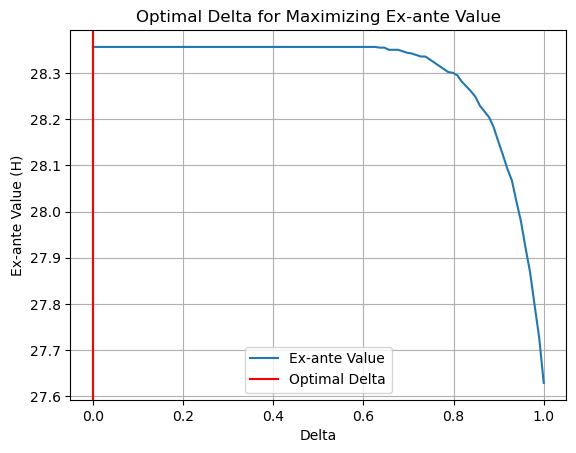

Optimal Delta = 0.000, Maximum Ex-ante Value (H) = 28.356


In [26]:
# Set the range of delta values to evaluate
delta_values = np.linspace(0, 1, 100)

# Calculate H for each delta value
H_values = []
for delta_val in delta_values:
    H = ex_ante_value(log_kappa_values, eta_val, w_val, delta_val, rng)
    H_values.append(H)

# Find the optimal delta that maximizes H
optimal_delta = delta_values[np.argmax(H_values)]
max_H = np.max(H_values)

# Plot the results
plt.plot(delta_values, H_values, label='Ex-ante Value')
plt.xlabel("Delta")
plt.ylabel("Ex-ante Value (H)")
plt.title("Optimal Delta for Maximizing Ex-ante Value")
plt.axvline(x=optimal_delta, color='r', linestyle='-', label='Optimal Delta')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Delta = {optimal_delta:.3f}, Maximum Ex-ante Value (H) = {max_H:.3f}")


*Here we see that the optimal $\Delta$ value is 0. That is, the salon should respond to each demand shock that may occur, in order to maximize profits. We also see that if the salon does not respond at all to the demand shocks, i.e., $\Delta=1$, the ex-ante expected value of the salon will still be positive, but significantly smaller than when $\Delta$ is small. This is due to the fact that $iota$ is significantly small. We remember that $iota$ is the fixed price adjustment cost of hiring or firing staff.*

*Furthermore, we see that there certainly is a mistake in our result. If $\Delta=0$ that would imply that the salon follows the exact same policy as in Question 2, which should then yield the same result for the ex-ante value as in Question 2. However, we are not able to obtain this, due to minor reference issues in our code, but we do acknowledge that the error is there.*


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



*For Question 5 we have set up an adaptive policy. By using an adaptive policy rule, we seek to adjust labor input based on a target indicator. Our target indicator is set up as a Boolean, giving the value "True" if the salon wants to increase the input of labor, and "False" if it wants to decrease labor input. By implementing this rule, the model should be more realistic in terms of labor market frictions and layoffs depending on the market situation.*

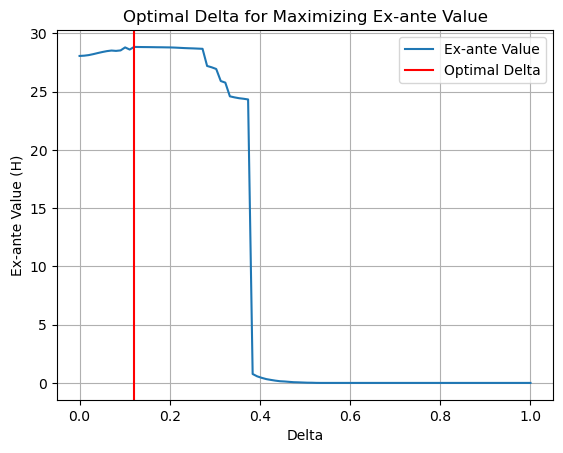

Optimal Delta = 0.121, Maximum Ex-ante Value (H) = 28.840


In [27]:
# For Question 5 we have set up an adaptive policy. By using an adaptive policy rule, we seek to adjust labor input based on a target
# indicator. Our target indicator is set up as a Boolean, giving the value "True" if the salon wants to increase the input of labor,
# and "False" if it wants to decrease labor input. By implementing this rule, the model should be more realistic in terms of labor
# market frictions and layoffs depending on the market situation.


# Set the baseline parameter values
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1 + 0.01) ** (1 / 12)

# Set seed
rng = np.random.default_rng(2023)

# Define the policy function
def policy_function(log_kappa_t, eta_val, w_val, delta_val, l_tm1):
    ell_ast = ((1 - eta_val) * np.exp(log_kappa_t) / w_val) ** (1 / eta_val)
    if np.abs(l_tm1 - ell_ast) > delta_val:
        return ell_ast
    else:
        return l_tm1

# Define the ex-ante value function
def ex_ante_value(log_kappa_values, eta_val, w_val, delta_val, rng):
    l_tm1 = 0  # Initial labor input
    h_values = []

    for log_kappa_t in log_kappa_values:
        eps_values = rng.normal(-0.5 * sigma_eps ** 2, sigma_eps, size=120)  # Generate shock series
        l_values = [policy_function(log_kappa_t[t], eta_val, w_val, delta_val, l_tm1) for t in range(120)]  # Calculate labor input based on policy function
        l_tm1 = l_values[-1]  # Update the previous labor input for the next iteration
        h_t = sum(R ** -t * (np.exp(log_kappa_t[t]) * l_values[t] ** (1 - eta_val) - w_val * l_values[t] - (l_values[t] != l_tm1) * iota) for t in range(120))  # Calculate ex-ante value for each period
        h_values.append(h_t)

    return np.mean(h_values)  # Calculate the average ex-ante value

# Set the number of shock series to simulate
K = 120

# Set the value of delta
delta_val = 0.05

# Define the adaptive policy function
def adaptive_policy(log_kappa_values, eta_val, w_val, rng):
    H_values = []
    delta_values = np.linspace(0, 1, 100) # Set the range of delta values to evaluate

    for delta_val in delta_values:
        H = ex_ante_value(log_kappa_values, eta_val, w_val, delta_val, rng) # Calculate the ex-ante value for each delta value
        H_values.append(H) # Append the ex-ante value to the list

    optimal_delta = delta_values[np.argmax(H_values)]
    max_H = np.max(H_values)

    # Plot the results
    plt.plot(delta_values, H_values, label='Ex-ante Value')
    plt.xlabel("Delta")
    plt.ylabel("Ex-ante Value (H)")
    plt.title("Optimal Delta for Maximizing Ex-ante Value")
    plt.axvline(x=optimal_delta, color='r', linestyle='-', label='Optimal Delta')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Optimal Delta = {optimal_delta:.3f}, Maximum Ex-ante Value (H) = {max_H:.3f}")

# Simulate K random shock series
log_kappa_values = rng.normal(0, sigma_eps, size=(K, 120))

# Calculate the optimal delta and maximum ex-post value
adaptive_policy(log_kappa_values, eta_val, w_val, rng)


*We see that the ex-ante expected value of the salon is 28.840, which is higher than what we obtained in Question 4. Furthermore, we see that the optimal delta now is $\Delta=0.121$, implying that when the salon decides on whether or not they should increase or decrease labor by the fixed amount of 0.1 for each period, the sensitivity to the demand shocks now play a less vital role in the decision making than in the previous questions.*

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [28]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

The optimal x1 is = -0.000
The optimal x2 is = -0.000
There by is the optimal f(x) = 0.000


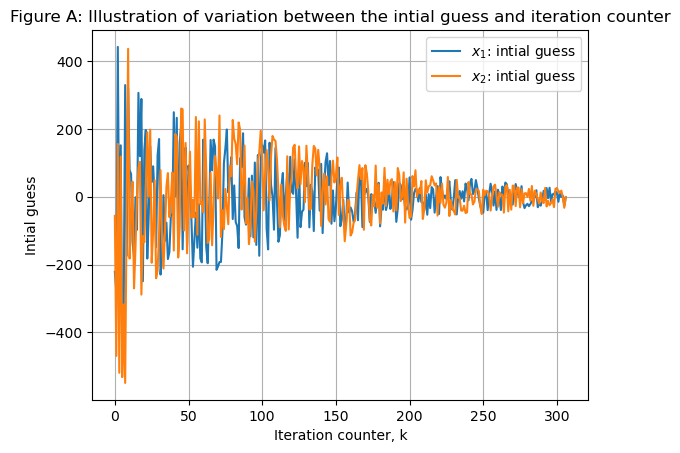

In [29]:
def global_optimizer(obj_func, tau, K_warmup, K_max):

    #Set the random seed to 420
    np.random.seed(seed=420)

    #Define x_star at the start to be 0
    x_star = 0

    # Define a list to store the values of x_k0, the intial guess
    x_k0_values = []
    
    #Define the settings bounds for x1 and x2 
    bounds = np.array([[-600, 600], [-600, 600]])

    #Define a loop, where k goes from 0 to 499
    for k in range(K_max):

        #Step A: Make sure that x_k (x1, x2) are drawn random uniformly within the given bounds [-600, 600]
        x_k = np.random.uniform(bounds[:, 0], bounds[:, 1])

        #Step B, B_2, C, D: 
        if k < K_warmup: #Step B: Define a if-else condition, that is k lower than K_warmup(10)
            x_k0 = x_k #Step B_2: If the condition is true, than the intial guess is the random uniformly drawn x_k 
        else:
            chi_k = 0.5 * (2 / (1 + np.exp((k - K_warmup) / 100))) #Step C: If the condition is not true, than we calulate chi_k 
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star #Step D: Further if the condition is not true, than we calulate the intial guess

        #Step E: We run a optimizer, where we minimize our function by respect to x1 and x2 by using the BFGS method, the intial guess and tolerance
        result = optimize.minimize(obj_func, x_k0, method='BFGS', tol=tau)

        #Step F: We make a if-condition, so if it is the first iteration (0),
        #or the value of our function with the current values of x1 and x2 is lower then value of our function with the previous optimal values of x1 and x2,
        #then we let the current values of x1 and x2 be our optimal values so far
        if k == 0 or result.fun < obj_func(x_star):
            x_star = result.x

        #We store the values of x_k0 in the list we made in the begin of the code
        x_k0_values.append(x_k0)
        
        #Step G: We make a if_conditiion, so if the value of our function with the current values of x1 and x2 is lower then our tolerance level (tau),
        #then we will break the loop and be satisfied. The current values of x1 and x2 will end up being our definitive optimal values
        if result.fun < tau:
            break

    #We return our definitive optimal values of x1 and x2 and all the intial guess 
    return x_star, x_k0_values


#Define rest of the settings
tau = 1e-8
K_warmup = 10
K_max = 1000 

#We call the global optimizer function
best_solution, x_k0_values = global_optimizer(griewank, tau, K_warmup, K_max)

#We print the results 
print(f'The optimal x1 is = {best_solution[0]:.3f}')
print(f'The optimal x2 is = {best_solution[1]:.3f}')
print(f'There by is the optimal f(x) = {griewank(best_solution):.3f}')

#Create a list of iteration values. It goes from 0 to the length of values of x_k0 in the list, we stored in our loop (x_k0_values)
k_values = range(len(x_k0_values))

#Create a list of the x1 values in the list of x_k0 values, we stored in our loop
x_k0_1values = [x[0] for x in x_k0_values]

#Create a list of the x2 values in the list of x_k0 values, we stored in our loop
x_k0_2values = [x[1] for x in x_k0_values]

#We create a plot, that illustrate how x_k0 vary with k
plt.plot(k_values, x_k0_1values, label='$x_1$: intial guess')
plt.plot(k_values, x_k0_2values, label='$x_2$: intial guess')
plt.grid(True)
plt.legend()
plt.xlabel('Iteration counter, k')
plt.ylabel('Intial guess')
plt.title('Figure A: Illustration of variation between the intial guess and iteration counter')
plt.show()

By using our implemented refined global optimizer with multi-start we ended up with the optimal values of $x_1^*=x_2^*=0$ and $f(x^*)=0$. When looking at figure A we can see how intial guess vary with the iteration counter. The variation of the intial guess for both $x_1$ and $x_2$ decreases in number of the iterations, especially after the number 10 iteration, where the intial guess no longer are the randomly uniformly drawn, $x^k$. We can also see, that our implemented refined global optimizer with multi-start reachs the optimal values around number 320 of the iterations

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

The optimal x1 is = -0.000
The optimal x2 is = 0.000
There by is the optimal f(x) = 0.000


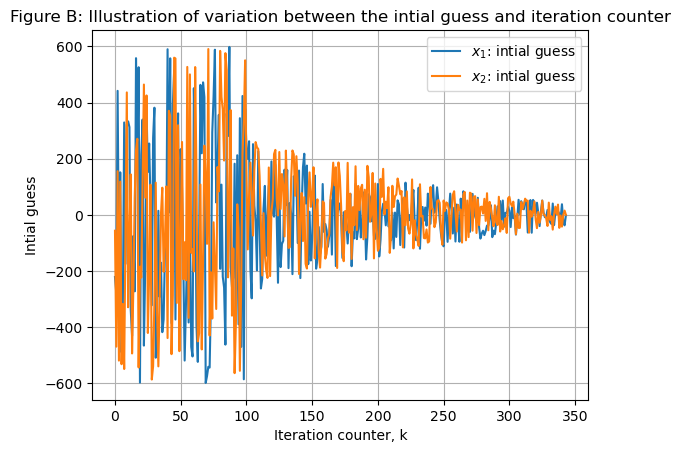

In [30]:
#define warm-up iteration to be 100 now
K_warmup = 100

#We call the global optimizer function
best_solution, x_k0_values = global_optimizer(griewank, tau, K_warmup, K_max)

#We print the results 
print(f'The optimal x1 is = {best_solution[0]:.3f}')
print(f'The optimal x2 is = {best_solution[1]:.3f}')
print(f'There by is the optimal f(x) = {griewank(best_solution):.3f}')

#Create a list of iteration values. It goes from 0 to the length of values of x_k0 in the list, we stored in our loop (x_k0_values)
k_values = range(len(x_k0_values))

#Create a list of the x1 values in the list of x_k0 values, we stored in our loop
x_k0_1values = [x[0] for x in x_k0_values]

#Create a list of the x2 values in the list of x_k0 values, we stored in our loop
x_k0_2values = [x[1] for x in x_k0_values]

#We create a plot, that illustrate how x_k0 vary with k
plt.plot(k_values, x_k0_1values, label='$x_1$: intial guess')
plt.plot(k_values, x_k0_2values, label='$x_2$: intial guess')
plt.grid(True)
plt.legend()
plt.xlabel('Iteration counter, k')
plt.ylabel('Intial guess')
plt.title('Figure B: Illustration of variation between the intial guess and iteration counter')
plt.show()

When we set $\underline{K} = 100$ the optimal values remain the same, $x_1^*=x_2^*=0$ and $f(x^*)=0$. We see the same trend in figure B as in figure A, when $\underline{K} = 10$. The variation of the intial guess for both $x_1$ and $x_2$ decreases in number of the iterations, but in contrary to figure A the variation first decreases after number 100 of the iterations. This happends because the intial guess now are the randomly uniformly drawn, $x^k$, up to number 100 of the iterations instead of number 10 in figure A. We can also see in figure B, that our implemented refined global optimizer with multi-start, when $\underline{K} = 100$, reachs the optimal values around number 460 of the iterations. We can therefore conclude thar the convergence becomes slower, when we increase the warm-up iterations, $\underline{K}$, to 100.